In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
!pip install dotmap

from dotmap import DotMap
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.stats import norm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

from google.colab import drive
drive.mount('/content/gdrive')
save_path_prefix = '/content/gdrive/My Drive/Colab Notebooks/saved/QDL_01'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


KeyboardInterrupt: ignored

In [0]:


def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1, nrows=None, ncols=None, fig_width=30):
  s = images.shape

  assert len(s) == 3
  
  if nrows is None or ncols is None:
    resolution = int(s[0] ** 0.5)
    nrows = resolution
    ncols = resolution

  assert images.shape[0] == nrows * ncols, f"{images.shape[0]} != {nrows} * {ncols}"

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_width * nrows / ncols),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

# Creates pdf for each item
# (input_count, feature_count, height, width) => (input_count, feature_count * resolution, height, width)
def to_pdf(mu, var, resolution=10):
  mu_shape = mu.shape
  input_count, feature_count, height, width = mu_shape
  step = 1.0 / (resolution + 1)

  assert mu_shape == var.shape
  assert resolution > 0
  assert resolution < 50
  
  # mu and logvar: move features to the end and flatten
  print("to_pdf: mu", mu.shape)
  mu_combined = mu.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: mu_combined", mu_combined.shape)

  var = torch.clamp(var, step * 0.005, 3.0)
  
  var_combined = var.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: var_combined", var_combined.shape)

  # pdf for each item
  rr = np.arange(step, 1, step)
  pdfs = []
  for i in np.arange(mu_combined.shape[0]):
    pdf = norm.pdf(rr, mu_combined[i], var_combined[i])
    pdf = pdf / pdf.sum()
    pdfs.append(pdf)
  
  mu__ = torch.as_tensor(pdfs)
  print("to_pdf: mu__", mu__.shape) # (*, resolution)

  mu__ = mu__.view(-1, feature_count, resolution)
  print("to_pdf: mu__", mu__.shape) # (*, feature_count, resolution)
  
  mu__ = mu__.view(input_count, height, width, feature_count * resolution).contiguous()
  print("to_pdf: mu__", mu__.shape) # (input_count, height, width, feature_count * resolution)

  #mu__ = mu__.permute(0, 3, 1, 2).contiguous() # (input_count, feature_count * resolution, height, width)
  #print("to_pdf: mu__", mu__.shape)
  
  return mu__

# plt.plot(to_pdf(torch.tensor([[[[0.49]]]]), torch.tensor([[[[0.04]]]]), resolution=40).reshape(-1, 1).numpy())

to_pdf: mu torch.Size([1, 1, 1, 10])
to_pdf: mu_combined (10,)
to_pdf: var_combined (10,)
to_pdf: mu__ torch.Size([10, 10])
to_pdf: mu__ torch.Size([10, 1, 10])
to_pdf: mu__ torch.Size([1, 1, 10, 10])
tensor([[0.0000],
        [0.1000],
        [0.7000],
        [0.6000],
        [0.5000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000]])


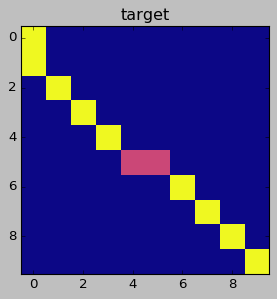

Epoch: 0 	 Loss: 0.298288


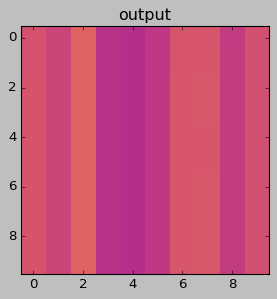

output sums tensor([5.0344, 5.0359, 5.0427, 5.0419, 5.0411, 5.0411, 5.0419, 5.0427, 5.0433,
        5.0437], grad_fn=<SumBackward2>)
Epoch: 5000 	 Loss: 0.053972


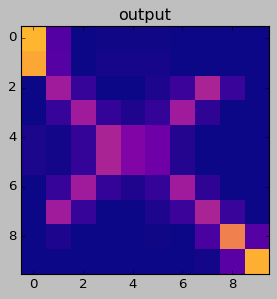

output sums tensor([1.0087, 0.9900, 1.0016, 1.0048, 0.9886, 0.9886, 1.0048, 1.0016, 0.9912,
        0.9904], grad_fn=<SumBackward2>)
Epoch: 10000 	 Loss: 0.053861


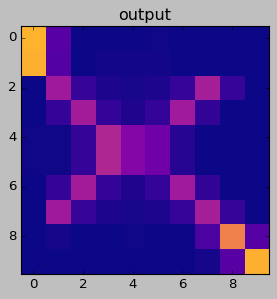

output sums tensor([0.9998, 1.0007, 1.0027, 1.0044, 1.0059, 1.0059, 1.0044, 1.0027, 0.9965,
        0.9976], grad_fn=<SumBackward2>)
x tensor([[0.9000],
        [0.8000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000]])


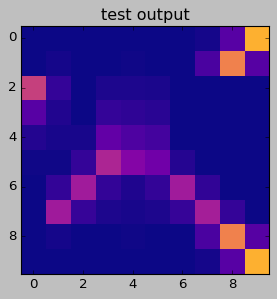

x tensor([[0.8500],
        [0.7500],
        [0.1500],
        [0.2500],
        [0.3500],
        [0.4500],
        [0.5500],
        [0.6500],
        [0.7500],
        [0.8500]])


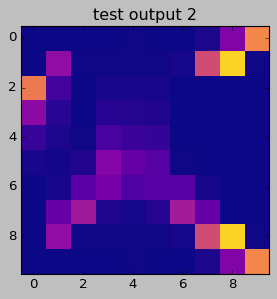

x tensor([[0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900],
        [0.1000],
        [0.1100],
        [0.1200],
        [0.1300],
        [0.1400],
        [0.1500],
        [0.1600],
        [0.1700],
        [0.1800],
        [0.1900],
        [0.2000],
        [0.2100],
        [0.2200],
        [0.2300],
        [0.2400]])


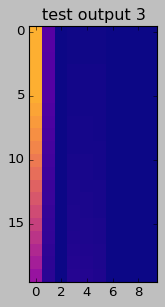

In [56]:
#Learn x -> QD(y)
class QDL(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, resolution):
    super(QDL, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.DEBUG)

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.resolution = resolution

    self.fc1 = nn.Linear(input_size,  hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.fc5 = nn.Linear(hidden_size, output_size * resolution)

    
  def forward(self, x):
    #print("forward()")
    #print("x", x)
    #x = F.relu(self.fc1(x))
    # x = F.sigmoid(self.fc2(x))
    #x = torch.sigmoid(self.fc2(x))

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = torch.sigmoid(x)



    return x
  
def train(model, device, data, target, optimizer, epochs, log_interval):
  model.train()
  data, target = data.to(device), target.to(device)
  show_image(target.detach(), title="target", print_values=False, vmin=0, vmax=1)
  for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(data)
    #print("output", output)
    loss = F.mse_loss(output, target)
    
    # smoothness
    loss += (output[:, 0:-1] - output[:, 1:]).pow(2).mean().pow(0.5) * 0.1
    
    # should sum to 1
    loss += (output.sum(dim=1) - 1).pow(2).mean().pow(0.5) * 0.01
    
    loss.backward()
    optimizer.step()
    if epoch % log_interval == 0:
      print(f"Epoch: {epoch} \t Loss: {loss.item():.6f}")
      show_image(output.detach(), title="output", print_values=False, vmin=0, vmax=1)
      print("output sums", output.sum(dim=1))
      if loss < 0.0001:
        break

resolution = 10

x = torch.tensor(np.arange(0, 1, 0.1)).unsqueeze(0).unsqueeze(0).unsqueeze(0)
var = torch.ones(x.shape) * 0.005

y = to_pdf(x, var, resolution=resolution)

x = x.squeeze().unsqueeze(-1).float()
y = y.squeeze().float()

x[2:5] = 0.9 - x[2:5]
print(x)
#print(y)

model = QDL(input_size=1, hidden_size=resolution, output_size=1, resolution=resolution)

#for param in model.parameters():
    # print(type(param.data), param.size())
    #nn.init.constant(param.data, val=0.1)
    #param.data += 0.1
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, device=device, data=x, target=y, optimizer=optimizer, epochs=10001, log_interval=5000)

x[0:5] = 0.9 - x[0:5]
output = model(x)
print("x", x)
show_image(output.detach(), title="test output", print_values=False, vmin=0, vmax=1)

x = x - 0.05
output = model(x)
print("x", x)
show_image(output.detach(), title="test output 2", print_values=False, vmin=0, vmax=1)

x = torch.tensor(np.arange(.05, .25, 0.01)).unsqueeze(-1).float()
output = model(x)
print("x", x)
show_image(output.detach(), title="test output 3", print_values=False, vmin=0, vmax=1)

# QDL (Quantized Distribution Learning)

x is R
y in R
QD(y) is R^r
where r = quantization resolution

Input x = 0.5, resolution = 5, y = 0.5, then QD(y) ~= [0, 0, 1, 0, 0]

## Representing ambiguity
In this demo dataset, f(x=0.7) == 0.7 and f(x=0.7) = 0.2, i.e. f(x) is ambiguous. Thus for x = 0.7, QD(y) that the network trains on is either appox [0 0 0 1 0] or appox [0 1 0 0 0]. After training, output is average of the two, i.e. [0 0.5 0 0.5 0].

## Smoothness regularizer
Note that we can use a regularizer to encourage smoothness in the learned QD. The regularizer adds L2 norm of average squared difference between successive values in the QD. With this regularizer, the output for x=0.7 in the above example would become something like [0.1 0.3 0.1 0.3 0.1]

## Test output
The test x samples are 0.1 0.2 ... 0.9. For x = 0.5 to 0.9, we see expected output. For x = 0.1 to 0.4, ideally we get a zero output, but we get the same output as x=0.5. 

Why ideally zero output for x=0.1? because there was no test data that covered that range and ideally we would indicate low confidence. What can be done to make that so? We would ideally have sum of a QD's items to be small to indicate low confidence and high to indicate high confidence.

## Test output 2
Here we present x values 0.05, 0.15, ... , 0.85. These values were not part of the training set, so good output on these values indicates generalization.

## Test output 3
Values (0.05-0.25) partially outside the training range (0-2-0.9)